# Results

## Data Loading

In [1]:
suppressWarnings(suppressMessages(library("tidyverse")))
suppressWarnings(suppressMessages(library("ggpubr")))
suppressWarnings(suppressMessages(library("rstatix")))
suppressWarnings(suppressMessages(library("plyr")))

library(tidyverse)
library(ggpubr)
library(rstatix)
library(plyr)

map_abb <- list("df"="DF", "gm"="GM","wm"="WM", "csf"="CSF")

df_eval <- list("crossval"= data.frame(), "test"= data.frame())


for (evaluation in names(df_eval)){
    for (mod in names(map_abb)){

      filename <- sprintf("%s_%s.csv", mod, evaluation)
      path_col <- file.path(getwd(), "..", "..", "..", "resources", filename)
      
      df_mod <- read.csv(path_col)
      df_mod$modality <- map_abb[[mod]]

      df_eval[[evaluation]] <- rbind(df_eval[[evaluation]], df_mod)
    }
}

df_val <- df_eval[["crossval"]]
df_test <- df_eval[["test"]]


#### Validation data

In [2]:
head(df_val)

fold MAE      r2        modality
1 0    4.910286 0.8573168 DF      
2 1    4.177728 0.7937252 DF      
3 2    6.336831 0.7525602 DF      
4 3    6.220759 0.7729788 DF      
5 4    5.494937 0.7465731 DF      
6 5    6.471542 0.7765924 DF

In [3]:
aggregate(df_val[,c("r2", "MAE")], list(df_val$modality), mean)

Group.1 r2        MAE     
1 CSF     0.7068463 6.609508
2 DF      0.7616746 5.843714
3 GM      0.7508428 6.140916
4 WM      0.7235893 6.501720

#### Test data

In [4]:
head(df_test)

subjectID gender age   y_hat    modality
1 sub-517   0      36.16 40.94362 DF      
2 sub-303   0      25.46 37.59454 DF      
3 sub-232   1      28.81 35.01436 DF      
4 sub-462   1      75.08 67.79715 DF      
5 sub-331   0      23.49 30.64490 DF      
6 sub-294   1      27.08 29.80392 DF

In [5]:
df_test["abs_diff"] <- abs(df_test$y_hat - df_test$age)

result_mean <- aggregate(df_test[,c("age", "y_hat", "abs_diff")], list(df_test$modality), mean)
result_mean

Group.1 age      y_hat    abs_diff
1 CSF     42.37309 49.54023 9.124851
2 DF      42.37309 46.25928 7.096847
3 GM      42.37309 45.49686 7.956941
4 WM      42.37309 37.31041 9.990654

## Statistics

### Repeated Measures ANOVA

In [6]:
df_val$modality <- factor(df_val$modality)

res.aov <- anova_test(data = df_val, dv = MAE, wid = fold, within = modality)
get_anova_table(res.aov)


Effect   DFn DFd F     p     p<.05 ges 
1 modality 3   87  5.701 0.001 *     0.06

#### Post-hoc analysis

In [7]:

pwc <- df_val %>%
  pairwise_t_test(
    MAE ~ modality, paired = TRUE,
    p.adjust.method = "bonferroni"
  )
pwc <- pwc %>% add_xy_position(x = "modality")
pwc

.y. group1 group2 n1 n2 statistic  df p        p.adj    p.adj.signif
1 MAE CSF    DF     30 30  4.4361533 29 0.000121 0.000726 ***         
2 MAE CSF    GM     30 30  2.0552780 29 0.049000 0.294000 ns          
3 MAE CSF    WM     30 30  0.4207693 29 0.677000 1.000000 ns          
4 MAE DF     GM     30 30 -1.5010999 29 0.144000 0.864000 ns          
5 MAE DF     WM     30 30 -3.4434066 29 0.002000 0.011000 *           
6 MAE GM     WM     30 30 -1.9403815 29 0.062000 0.373000 ns          
  y.position groups   xmin xmax
1  9.418840  CSF, DF  1    2   
2  9.621448  CSF, GM  1    3   
3  9.824056  CSF, WM  1    4   
4 10.026664  DF, GM   2    3   
5 10.229272  DF, WM   2    4   
6 10.431880  GM, WM   3    4

Warning message in if (fill %in% names(data) & is.null(add.params$fill)) add.params$fill <- fill:
“the condition has length > 1 and only the first element will be used”


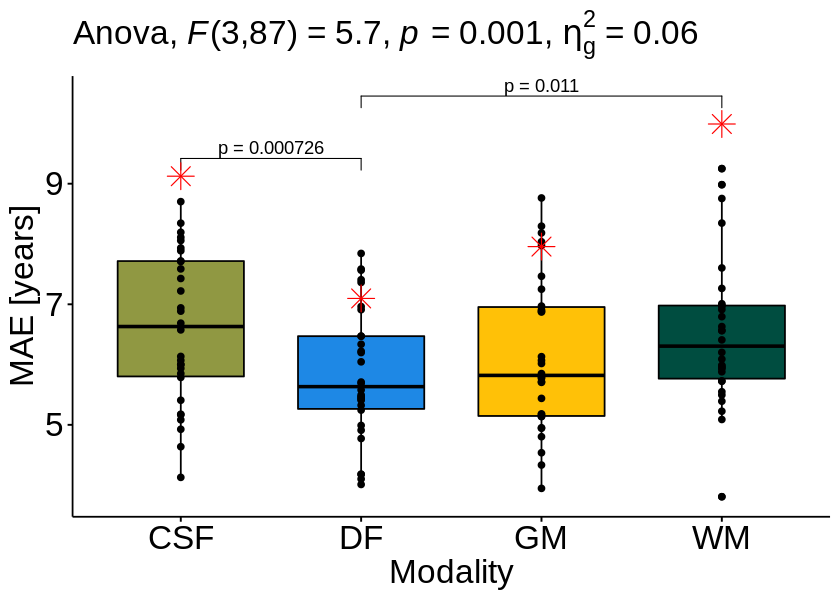

In [8]:
colors <- c("#909842", "#1E88E5", "#FFC107", "#004D40")

options(repr.plot.width = 7, repr.plot.height = 5)


bxp <- ggboxplot(df_val, x = "modality", y = "MAE", add = "point", 
                 xlab = "Modality", ylab = "MAE [years]", fill=colors) + theme(text = element_text(size=20))


bxp <- bxp + 
  stat_pvalue_manual(pwc, hide.ns = TRUE, coord.flip=FALSE, label = "p = {p.adj}", step.increase=0.035) +
  labs(
    subtitle = get_test_label(res.aov, detailed = TRUE),
  )

# add the MAE results for the test set
bxp <- bxp + geom_point(data = data.frame(x = factor(result_mean[["Group.1"]]), y = result_mean[["abs_diff"]]),
                   aes(x=x, y=y),
                   color = 'red', shape=8, size=5)


bxp